In [26]:
# set up

import os
import re
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC

# os.chdir("/content/CPEG-CAPSTONE/ML/dual_emg")
print("current directory:", os.getcwd())
print("sample files:", sorted(f for f in os.listdir() if f.endswith(".csv"))[:10])


Current directory: /content/CPEG-CAPSTONE/ML/dual_emg
Sample files: ['closed_fist_M1_1.csv', 'closed_fist_M1_10.csv', 'closed_fist_M1_11.csv', 'closed_fist_M1_12.csv', 'closed_fist_M1_13.csv', 'closed_fist_M1_14.csv', 'closed_fist_M1_15.csv', 'closed_fist_M1_16.csv', 'closed_fist_M1_2.csv', 'closed_fist_M1_3.csv']


## ANALYSIS

In [27]:
# EMG feature extraction for a single window

def compute_features(signal: np.ndarray) -> dict:
    """
    Compute multiple EMG features for one window of samples.
    These features will be computed separately for M1 and M2 and then concatenated.
    """
    signal = np.asarray(signal, dtype=float)
    feats = {}
    feats["rms"] = np.sqrt(np.mean(signal**2))
    feats["mav"] = np.mean(np.abs(signal))
    feats["wl"]  = np.sum(np.abs(np.diff(signal)))
    feats["zc"]  = np.sum(np.diff(np.sign(signal)) != 0)
    feats["var"] = np.var(signal)
    feats["max"] = np.max(signal)
    feats["min"] = np.min(signal)
    feats["ptp"] = np.ptp(signal)  # peak-to-peak
    return feats


In [28]:
# extract windowed features from a pair of files

def extract_window_features_from_pair(df1: pd.DataFrame,
                                      df2: pd.DataFrame,
                                      win: int = 200,
                                      step: int = 200,
                                      label: str = None):
    # grab EMG signals from 'value' column for each sensor
    sig1 = pd.to_numeric(df1["value"], errors="coerce").dropna().to_numpy()
    sig2 = pd.to_numeric(df2["value"], errors="coerce").dropna().to_numpy()

    # align lengths --> truncate to min length to keep them synced
    N = min(len(sig1), len(sig2))
    sig1 = sig1[:N]
    sig2 = sig2[:N]

    if label is None:
        # use the label column from df1
        label = str(df1["label"].iloc[0])

    X, y = [], []
    for start in range(0, N - win + 1, step):
        end = start + win
        w1 = sig1[start:end]
        w2 = sig2[start:end]

        f1 = compute_features(w1)
        f2 = compute_features(w2)

        X.append(list(f1.values()) + list(f2.values()))
        y.append(label)

    return np.array(X), np.array(y)


In [35]:
# load all M1/M2 CSV pairs and build feature matrix

all_X = []
all_y = []

# find all M1 files
m1_files = sorted(glob("*_M1_*.csv"))
print("found M1 files:", m1_files)

for f1 in m1_files:
    # get M2
    f2 = f1.replace("_M1_", "_M2_")
    if not os.path.exists(f2):
        print(f"[ERROR] missing M2 pair for {f1} (expected {f2})")
        continue

    df1 = pd.read_csv(f1)
    df2 = pd.read_csv(f2)

    label = str(df1["label"].iloc[0])

    X_sess, y_sess = extract_window_features_from_pair(df1, df2, win=50, step=25, label=label)

    if X_sess.size == 0:
        print(f" [ERROR] no windows extracted for pair {f1} / {f2}")
        continue

    all_X.append(X_sess)
    all_y.append(y_sess)

X = np.vstack(all_X)
y = np.concatenate(all_y)

print("final feature matrix shape X:", X.shape)   # (num_windows, num_features)
print("labels present:", np.unique(y))


Found M1 files: ['closed_fist_M1_1.csv', 'closed_fist_M1_10.csv', 'closed_fist_M1_11.csv', 'closed_fist_M1_12.csv', 'closed_fist_M1_13.csv', 'closed_fist_M1_14.csv', 'closed_fist_M1_15.csv', 'closed_fist_M1_16.csv', 'closed_fist_M1_2.csv', 'closed_fist_M1_3.csv', 'closed_fist_M1_4.csv', 'closed_fist_M1_5.csv', 'closed_fist_M1_6.csv', 'closed_fist_M1_7.csv', 'closed_fist_M1_8.csv', 'closed_fist_M1_9.csv', 'flat_hand_M1_1.csv', 'flat_hand_M1_10.csv', 'flat_hand_M1_11.csv', 'flat_hand_M1_2.csv', 'flat_hand_M1_3.csv', 'flat_hand_M1_4.csv', 'flat_hand_M1_5.csv', 'flat_hand_M1_6.csv', 'flat_hand_M1_7.csv', 'flat_hand_M1_8.csv', 'flat_hand_M1_9.csv']
Final feature matrix shape X: (415, 16)
Labels present: ['closed_fist' 'flat_hand']


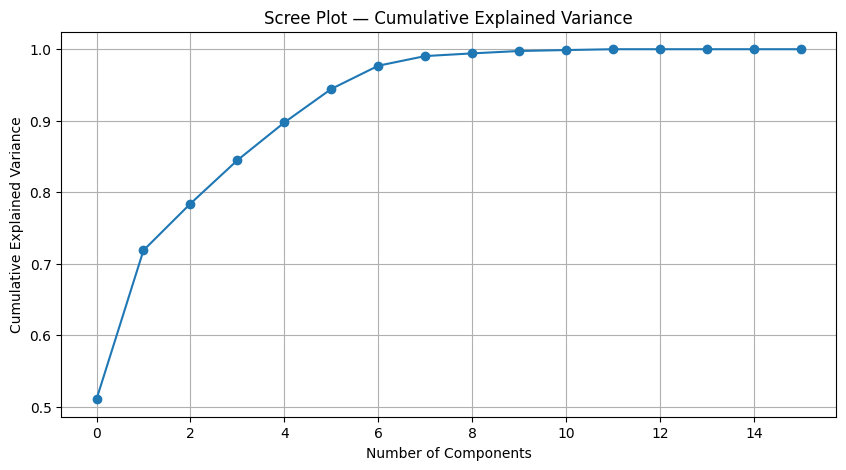

PC1: 0.5103
PC2: 0.2083
PC3: 0.0654
PC4: 0.0607
PC5: 0.0528
PC6: 0.0470
PC7: 0.0325
PC8: 0.0135
PC9: 0.0038
PC10: 0.0034


In [36]:
# -scale data and run PCA

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA()
pca.fit(X_scaled)

explained = pca.explained_variance_ratio_

# scree plot
plt.figure(figsize=(10,5))
plt.plot(np.cumsum(explained), marker='o')
plt.title("Scree Plot")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True)
plt.show()

for i, v in enumerate(explained[:10]):
    print(f"PC{i+1}: {v:.4f}")


In [44]:
# pca
elbow = 5  # GET FROM GRAPH

pca = PCA(n_components=elbow)
X_pca = pca.fit_transform(X_scaled)

print("New PCA-transformed shape:", X_pca.shape)


New PCA-transformed shape: (415, 5)


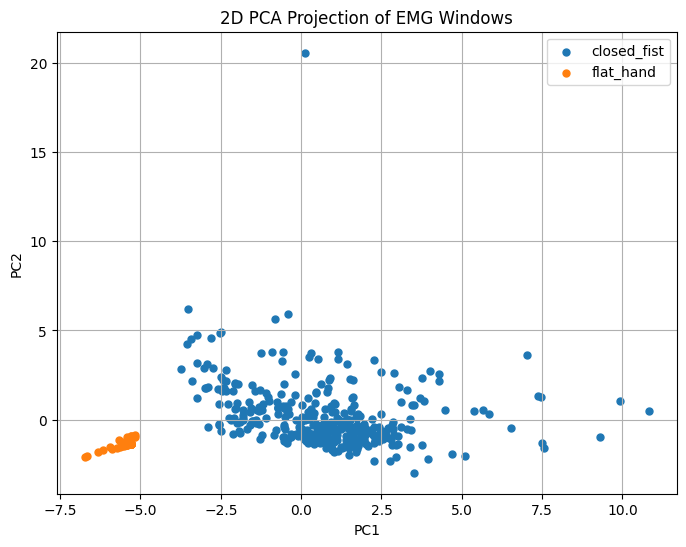

In [46]:
# pca visualization (my sanity helper)

pca2 = PCA(n_components=2)
X_2D = pca2.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
for lab in np.unique(y):
    idx = (y == lab)
    plt.scatter(X_2D[idx,0], X_2D[idx,1], s=25, label=lab)

plt.title("2D PCA Projection of EMG Windows")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.grid(True)
plt.show()


In [45]:
# train test split

X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42, stratify=y)

print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (332, 5) Test: (83, 5)


In [47]:
# grid search for svm set up

param_grid = {"kernel": ["linear", "rbf", "poly"],"C": [0.1, 1, 10, 50],"gamma": ["scale", "auto", 0.01, 0.001]}

grid = GridSearchCV(SVC(),param_grid,cv=5,scoring="accuracy",n_jobs=-1,verbose=2)

grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)
print("Best CV accuracy:", grid.best_score_)


Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best parameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Best CV accuracy: 1.0



Classification Report:

              precision    recall  f1-score   support

 closed_fist       1.00      1.00      1.00        73
   flat_hand       1.00      1.00      1.00        10

    accuracy                           1.00        83
   macro avg       1.00      1.00      1.00        83
weighted avg       1.00      1.00      1.00        83



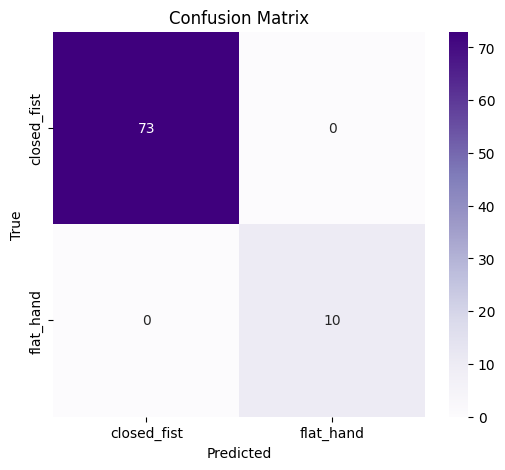

In [48]:
# best model & confusion matrix

best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, labels=np.unique(y))

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples",
            xticklabels=np.unique(y),
            yticklabels=np.unique(y))
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [41]:
# save and scale for Pi/ESP32

import joblib

joblib.dump(best_model, "best_svm_model.pkl")
joblib.dump(scaler, "scaler.pkl")

print("Saved model → best_svm_model.pkl")
print("Saved scaler → scaler.pkl")


Saved model → best_svm_model.pkl
Saved scaler → scaler.pkl
